In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn 

In [2]:
#Read main data to DataFrame
cleaned_df = pd.read_csv('processed_data/cleaned_df.csv', index_col=0)  

In [3]:
df_original = pd.read_stata('Cash_and_Childhood_Development_Replication/macoursetal_main.dta')  

df_out=df_original[["a5sscore_i_06","a6smemory_p1_06","a6smemory_p2_06","a7a_delay_06","a7b_delay_06",
        "a7c_delay_06","a7d_delay_06","a9sgrossmotor_06","height_06","weight_06","z_tvip_06","z_social_06",
        "z_language_06","z_finmotor_06","z_memory_06","z_grmotor_06","z_legmotor_06","z_behavior_06","z_height_06",
        "z_weight_06","z_all_06"]]

In [4]:
cleaned_df.drop(cleaned_df[df_out.iloc[cleaned_df.index].z_all_06.isna()].index, axis=0, inplace=True)

In [5]:
cleaned_df["z_all_06"]=df_out.iloc[cleaned_df.index].z_all_06

In [6]:
cp_cols=["hogarid_old"]

In [7]:
cleaned_df.drop(cp_cols, axis=1, inplace=True)

In [8]:
def outlier_removal(df, cols):
    outlier_threshold = []
    for col in cols:
            q3 = np.nanpercentile(df[col], 75)
            q1 = np.nanpercentile(df[col], 25)
            iqr = q3 - q1
            out_low = q1 - 3*iqr
            out_high = q3 + 3*iqr
            outlier_threshold.append([out_low, out_high])
    outliers_indexs=[]
    for col,k in zip(cols,range(len(cols))):
        #outliers_indexs_in_col=[]
        for i in df[col].index:
            if df[col][i]<outlier_threshold[k][0] or df[col][i]>outlier_threshold[k][1]:
                outliers_indexs.append(i)
        #outliers_indexs.append(outliers_indexs_in_col)
    return df.drop(list(set(outliers_indexs)), axis=0)

cleaned_df=outlier_removal(cleaned_df, ["z_all_06"])

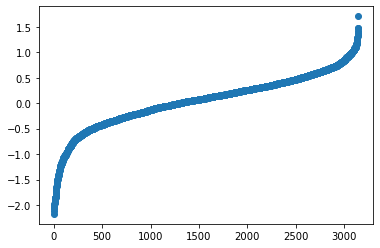

In [9]:
plt.scatter([i for i in range(len(cleaned_df["z_all_06"].sort_values().values))], cleaned_df["z_all_06"].sort_values().values)

(array([ 22.,  29.,  72., 166., 517., 921., 907., 409.,  96.,   6.]),
 array([-2.1753304 , -1.7871083 , -1.3988862 , -1.0106641 , -0.62244195,
        -0.23421985,  0.15400226,  0.54222435,  0.9304465 ,  1.3186686 ,
         1.7068907 ], dtype=float32),
 <BarContainer object of 10 artists>)

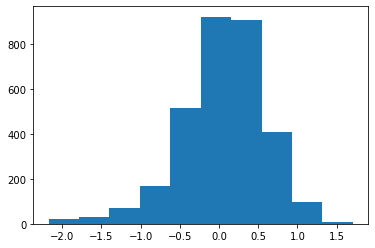

In [10]:
plt.hist(cleaned_df["z_all_06"])

In [11]:
cleaned_df["zall06_cat"] = pd.cut(cleaned_df["z_all_06"],
                               bins=[-np.inf, -0.75, -0.25, 0.25, 0.75, np.inf],
                               labels=[1, 2, 3, 4, 5])

In [12]:
cleaned_df["zall06_cat"].value_counts().sort_values()

1     204
5     212
2     574
4     962
3    1193
Name: zall06_cat, dtype: int64

In [13]:
treatment = 'tr'
outcome = 'z_all_06'
covariates = list(cleaned_df.columns)
covariates.remove(treatment)
covariates.remove(outcome)
covariates.remove("zall06_cat")

In [14]:
cleaned_df.z_all_06.values

array([ 0.45015588,  0.01125175, -0.5053326 , ...,  0.43954134,
        0.03532236, -0.03708899], dtype=float32)

In [15]:
from sklearn.model_selection import train_test_split
# split data into train and test sets 
train, test = train_test_split(cleaned_df, stratify=cleaned_df.zall06_cat, test_size=0.2, random_state=0)

# set variables for causal forest Y=outcome, T=treatment, X=covariates, W=effect_modifiers 
y_train = train[outcome]
X_train = train[covariates+["tr"]]
X_train_all=train[covariates+["tr"]+[outcome]]

X_test = test[covariates+["tr"]]
y_test =  test[outcome]
X_test_all=test[covariates+["tr"]+[outcome]]

In [16]:
def display_scores(scores,model_name = None):
    if(model_name):
        print("----",model_name,"----")
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [17]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(clf, X_train, y_train, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=clf,
        X=X_train,
        y=y_train,
        cv=3,
        scoring="neg_root_mean_squared_error",
        train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    )

    train_mean = -train_scores.mean(axis=1)
    test_mean = -test_scores.mean(axis=1)

    plt.subplots(figsize=(5,4))
    plt.plot(train_sizes, train_mean, label="train")
    plt.plot(train_sizes, test_mean, label="validation")
    #plt.ylim(0,0.55)

    plt.title("Learning Curve"+title)
    plt.xlabel("Training Set Size")
    plt.ylabel("RMSE")
    plt.legend(loc="best")

    plt.show()

In [18]:
import lightgbm as lgb

In [19]:
counterfactual_df=cleaned_df.drop(["z_all_06", "zall06_cat"],axis=1)
a=counterfactual_df["tr"]+1
counterfactual_df["tr"]=a%2

In [20]:
best_lightgbm =lgb.LGBMRegressor(application='regression_l2', boosting_type='gbdt', 
                                  colsample_bytree=0.3004571253236143, extra_trees=True, 
                                  learning_rate= 0.07116177177396639, max_depth= 164,
                                  min_child_weight= 0.00850418085429701, min_split_gain= 0.08258787964701664,
                                  n_estimators=353, num_leaves= 101, reg_alpha= 0.006378130018392472,
                                  reg_lambda=0.006971035283303719, subsample= 0.9530989839136036,
                                  subsample_for_bin= 819, subsample_freq= 6)

In [21]:
best_lightgbm.fit(X_train, y_train)
counterfactual=best_lightgbm.predict(counterfactual_df)

In [22]:
feature_importances=pd.Series(best_lightgbm.feature_importances_, index=X_train.columns).sort_values()

<AxesSubplot:>

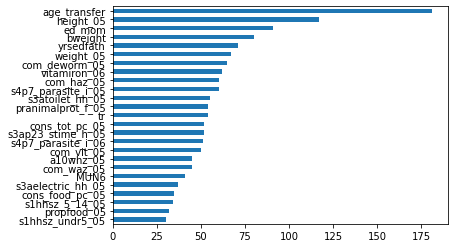

In [23]:
feature_importances[-25:].plot(kind='barh')

In [24]:
observed=cleaned_df["z_all_06"]
counterfactuals=pd.Series(counterfactual, index=observed.index)

In [25]:
ite_temp=pd.Series([observed[i]-counterfactuals[i] for i in observed.index if cleaned_df.tr[i]==1]
                   , index=cleaned_df[cleaned_df.tr==1].index)
ite_temp1=pd.Series([counterfactuals[i]-observed[i] for i in observed.index if cleaned_df.tr[i]==0]
                    , index=cleaned_df[cleaned_df.tr==0].index)
ite=pd.concat([ite_temp,ite_temp1])
ite.sort_index(inplace=True)

In [30]:
ite_df=counterfactual_df.copy()
ite_df.drop(["tr"], axis=1, inplace=True)
ite_df["ite"]=ite

In [31]:
ite_in=ite_df.drop("ite", axis=1).copy()

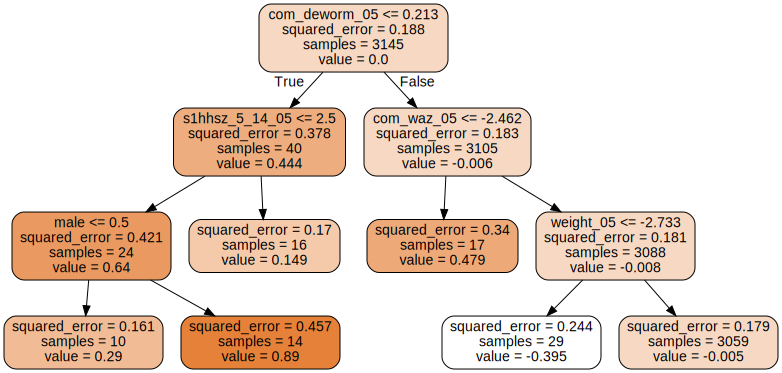

In [212]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
import graphviz
import os 

dec_tree= DecisionTreeRegressor(max_depth=3, min_samples_leaf=10).fit(ite_in, ite_df.ite)

dot_data = tree.export_graphviz(dec_tree, out_file=None, 
                                feature_names=ite_in.columns, filled=True,
                               rounded=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [310]:
dot_data = tree.export_graphviz(dec_tree, out_file=None, 
                                feature_names=ite_in.columns, filled=True,
                               rounded=True)


In [311]:
dot_data

'digraph Tree {\nnode [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;\nedge [fontname="helvetica"] ;\n0 [label="com_deworm_05 <= 0.213\\nsquared_error = 0.188\\nsamples = 3145\\nvalue = 0.0", fillcolor="#f7d8c2"] ;\n1 [label="s1hhsz_5_14_05 <= 2.5\\nsquared_error = 0.378\\nsamples = 40\\nvalue = 0.444", fillcolor="#eead7e"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="male <= 0.5\\nsquared_error = 0.421\\nsamples = 24\\nvalue = 0.64", fillcolor="#ea9a60"] ;\n1 -> 2 ;\n3 [label="squared_error = 0.161\\nsamples = 10\\nvalue = 0.29", fillcolor="#f1bc95"] ;\n2 -> 3 ;\n4 [label="squared_error = 0.457\\nsamples = 14\\nvalue = 0.89", fillcolor="#e58139"] ;\n2 -> 4 ;\n5 [label="squared_error = 0.17\\nsamples = 16\\nvalue = 0.149", fillcolor="#f4caab"] ;\n1 -> 5 ;\n6 [label="com_waz_05 <= -2.462\\nsquared_error = 0.183\\nsamples = 3105\\nvalue = -0.006", fillcolor="#f7d9c3"] ;\n0 -> 6 [labeldistance=2.5, labelangle=-45, headlabel="False

In [279]:
new_values=[0.14567]*11#aquest valors seran els cates de la funcio cate_tree que hi ha més avall

In [321]:
def replace_values (dot_data, new_values):
    inici=0
    for i in range(len(new_values)):
        index=dot_data[inici:].find("nvalue = ")+9+inici
        word=dot_data[index:index+6]
        long=len([int(s) for s in list(word) if s.isdigit()])
        signe=len([1 for s in list(word) if s=="-"])
        number=dot_data[index:index+long+1+signe]
        inici=index+long+1+signe
        old="nvalue = "+number
        new="nvalue = "+str(new_values[i])
        dot_data=dot_data.replace(old, new, 1)
    return dot_data

In [323]:
dot_data_new=replace_values (dot_data, new_values)

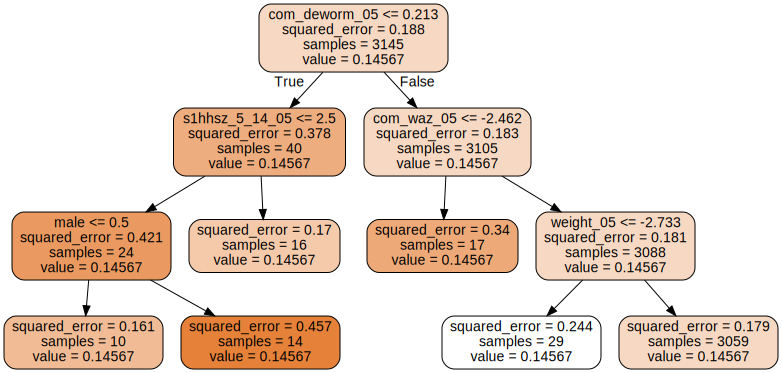

In [324]:
graph = graphviz.Source(dot_data_new, format="png") 
graph

In [196]:
#cate: donat un subgrup del nostre dataset, en calcula el cate

def cate(df):
    t=df[df.tr==1].z_al_06 
    c=df[df.tr==1].z_al_06
    
    if((len(t) or len(c))==0):
        cate= -999
    else:
        cate= np.mean(t)-np.mean(c)
    return cate

In [194]:
#donada una estructura d'arbre, i un dataset (control i tractament) retorna l'arbre amb el comput del cate a cada fulla

def cate_tree(dec_tree, df):
    tree_str=dec_tree.tree_
    
    #vector amb threshold dels splits (-2 si la fulla no te fills)
    threshold=tree_str.threshold 

    #vector amb variable usada en cada split
    numeric_features=tree_str.feature
    num_leaves=len(tree_str.feature)
    features=[]
    for i in numeric_features:
        if i>=0:
            features.append(ite_in.columns[i])
        else:
            features.append(-2)

    n_split=np.sum(threshold!=-2) #nombre de splits
    df_vec=[] #vector amb els df dels subgrups de df que cauen a cada fulla
    df_vec=[df.copy()]*n_leafs #posem el node inicial, els altres els reescriurem
    index_vec=[[0]] #vector amb 

    for i in range(n_split):
        for index in index_vec[i]: #per a cada nivell de l'arbre, creem un vector amb els fills de les fulles del nivell
            if  threshold[index]!=-2:
                left_children=tree_str.children_left[index]
                right_children=tree_str.children_right[index]
                index_vec.append( [left_children, right_children])

                father_df=df_vec[index].copy()
                df_vec[left_children]=father_df[father_df[features[index]]<=threshold[index]].copy()
                df_vec[right_children]=father_df[father_df[features[index]]>threshold[index]].copy()

